
## Baysebybackprop



In [1]:
import numpy as np

import torch
from torch import nn

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import scipy.special as ss
import sympy


In [95]:
a = torch.randn(4, 2)
print(a)
dim = a.size()
for _ in dim:
    a = torch.prod(a)
print(1e10)

tensor([[-0.3501, -0.9524],
        [-0.2444, -0.9060],
        [-0.2063,  0.2751],
        [-0.8497,  0.3380]])
10000000000.0


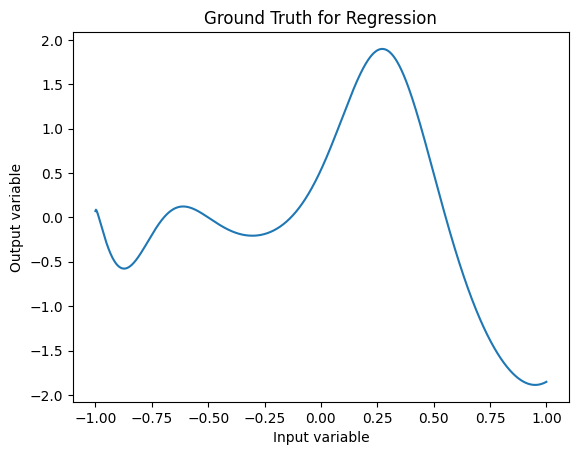

In [96]:
def unnormalised_ground_truth(x):
    """return the 'ground truth' output for a specific input location x"""
    return 15*np.cos(0.1/(0.05*(x+1)+0.02)) + 3*np.exp(0.5*np.sin(((50*(x+1))**0.9-3)/5))/((50*(x+1)+0.01)**(-0.5)) -12.5*(x+1)**2

def normalised_ground_truth(xs):
    ys = unnormalised_ground_truth(xs)
    m = ys.mean()
    s = ys.std()
    return (ys - m) / s

xs = np.linspace(-1, 1, 1000)
ys = normalised_ground_truth(xs)
plt.title("Ground Truth for Regression")
plt.plot(xs, ys)
plt.xlabel('Input variable')
plt.ylabel('Output variable')
plt.show()

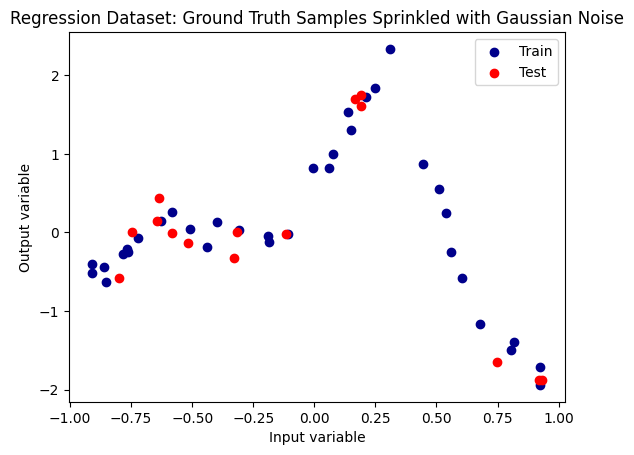

In [97]:
def generate_dataset(size=50, noise=0.15, split=0.3):
    xs = np.linspace(-1, 1, 1000)
    ys = normalised_ground_truth(xs)
    samp_ind = np.random.randint(0, 999, size)
    x_samps = xs[samp_ind]
    y_samps = ys[samp_ind] + np.random.normal(0, noise, size)
    return train_test_split(x_samps, y_samps, test_size=split, random_state=13)

x_tr, x_te, y_tr, y_te = generate_dataset()
plt.title("Regression Dataset: Ground Truth Samples Sprinkled with Gaussian Noise")
plt.scatter(x_tr, y_tr, label='Train', color='darkblue')
plt.scatter(x_te, y_te, label='Test', color='red')
plt.xlabel('Input variable')
plt.ylabel('Output variable')
plt.legend()
plt.show()

# transpose the pytorch tensor so it fits as expected later
x_tr = torch.FloatTensor(x_tr).unsqueeze(-1)
y_tr = torch.FloatTensor(y_tr).unsqueeze(-1)
x_te = torch.FloatTensor(x_te).unsqueeze(-1)
y_te = torch.FloatTensor(y_te).unsqueeze(-1)

In [101]:
class MeanFieldLayer_T(nn.Module):
    """Represents a mean-field Gaussian distribution over each layer of the network."""

    def __init__(self, input_dim, output_dim, deg_of_free, init_var=1e-3):
        super(MeanFieldLayer_T, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim

        # Prior parameters p(theta)
        self.w_mu_p = torch.zeros(input_dim, output_dim)
        self.w_log_var_p = torch.zeros(input_dim, output_dim)
        self.b_mu_p = torch.zeros(output_dim)
        self.b_log_var_p = torch.zeros(output_dim)
        self.deg_of_free = deg_of_free

        # Variational parameters q(theta)
        self.w_mu_q = nn.Parameter(torch.zeros(input_dim, output_dim), requires_grad=True)
        self.w_log_var_q = nn.Parameter(
            torch.ones(input_dim, output_dim) * torch.log(torch.tensor(init_var)), requires_grad=True
        )  
        self.b_mu_q = nn.Parameter(torch.zeros(output_dim), requires_grad=True)
        self.b_log_var_q = nn.Parameter(
            torch.ones(output_dim) * torch.log(torch.tensor(init_var)), requires_grad=True
        )

    # the priors do not change so could be stored as attributes, but
    # it feels cleaner to access them in the same way as the posteriors
    def p_w(self):
        """weight prior distribution"""
        #print('p_w',(0.5 * self.w_log_var_p).exp())
        return torch.distributions.StudentT(self.deg_of_free, self.w_mu_p, (0.5 * self.w_log_var_p).exp())

    def p_b(self):
        """bias prior distribution"""
        #print('p_b',(0.5 * self.b_log_var_p).exp())
        return torch.distributions.StudentT(self.deg_of_free, self.b_mu_p, (0.5 * self.b_log_var_p).exp())

    def q_w(self):
        """variational weight posterior"""
        #print('q_w',(0.5 * self.w_log_var_q).exp())
        return torch.distributions.StudentT(self.deg_of_free, self.w_mu_q, (0.5 * self.w_log_var_q).exp())

    def q_b(self):
        """variational bias posterior"""
        #print('q_b',(0.5 * self.b_log_var_q).exp())
        return torch.distributions.StudentT(self.deg_of_free, self.b_mu_q, (0.5 * self.b_log_var_q).exp())

    def ___log_det___(self, scale):
        copy = torch.log(torch.clone(scale))
        dim  = scale.size()
        for _ in dim:
            copy = torch.sum(copy)
        return copy



    def ___sum___(self, v1, loc1, loc2, scale1, scale2):
        summ = torch.tensor(0)
        size = loc1.size()
        n1   = size[0]
        if len(size) == 2:
            n2   = size[1]
            for i1 in range(n1):
                for i2 in range(n2):
                    summ = summ + ( v1/(v1 - 2)*scale1[i1, i2]  +  (loc1[i1, i2] - loc2[i1, i2])**2 )/scale2[i1, i2]
        else:
            for i1 in range(n1):
                summ = summ + ( v1/(v1 - 2)*scale1[i1]  +  (loc1[i1] - loc2[i1])**2 )/scale2[i1]
        return summ


    def ___kl___(self, v1, v2, loc1, loc2, scale1, scale2, k):
        log_scale = self.___log_det___(scale2) - self.___log_det___(scale1)
        if log_scale == torch.inf:
            print(scale2, scale1, self.___log_det___(scale2), self.___log_det___(scale1))
        sum_E     = self.___sum___(v1, loc1, loc2, scale1, scale2)
        #print('___kl___',log_scale, sum_E, 0.5 *( log_scale + (v2 + k)/v2 * sum_E - (v1 + k)/(v1 - 2)*k))
        return 0.5 *( log_scale + (v2 + k)/v2 * sum_E - (v1 + k)/(v1 - 2)*k)

    def kl(self):
        
        v1_w = self.q_w().df[0,0]
        loc1_w = self.q_w().loc
        scale1_w = self.q_w().scale
        v2_w = self.p_w().df[0,0]
        loc2_w = self.p_w().loc
        scale2_w = self.p_w().scale
        k_w = self.input_dim * self.output_dim
        #print(v1_w, v2_w, loc1_w, loc2_w, scale1_w, scale2_w, k_w)
        weight_kl = self.___kl___(v1_w, v2_w, loc1_w, loc2_w, scale1_w, scale2_w, k_w)

        v1_b = self.q_b().df[0]
        loc1_b = self.q_b().loc
        scale1_b = self.q_b().scale
        v2_b = self.p_b().df[0]
        loc2_b = self.p_b().loc
        scale2_b = self.p_b().scale
        k_b = self.output_dim
        
        bias_kl = self.___kl___(v1_b, v2_b, loc1_b, loc2_b, scale1_b, scale2_b, k_b)
        #print('w',weight_kl , 'b', bias_kl)
        return weight_kl + bias_kl

    def forward(self, x):
        """Propagates x through this layer by sampling weights from the posterior"""
        assert (len(x.shape) == 3), "x should be shape (num_samples, batch_size, input_dim)."
        assert x.shape[-1] == self.input_dim

        num_samples = x.shape[0]
        # rsample carries out reparameterisation trick for us  
         
        #print(self.q_w().df[0,0], self.q_w().loc, self.q_w().scale)
        weights = self.q_w().rsample((num_samples,))  # (num_samples, input_dim, output_dim).
        #print(self.q_b().df[0], self.q_b().loc, self.q_b().scale)
        biases = self.q_b().rsample((num_samples,)).unsqueeze(1)  # (num_samples, batch_size, output_dim)
        return x @ weights + biases # (num_samples, batch_size, output_dim).

    





class MeanFieldBNN(nn.Module):
    """Mean-field variational inference BNN."""

    def __init__(
        self,
        input_dim,
        hidden_dims,
        output_dim,
        activation=nn.ELU(),
        noise_std=1.0,
        deg_of_free = 4.0
    ):
        super(MeanFieldBNN, self).__init__()
        self.input_dim = input_dim
        self.hidden_dims = hidden_dims
        self.output_dim = output_dim
        self.activation = activation
        self.log_noise_var = torch.log(torch.tensor(noise_std**2))

        self.network = nn.ModuleList()
        for i in range(len(hidden_dims) + 1):
            if i == 0:
                self.network.append(MeanFieldLayer_T(self.input_dim, self.hidden_dims[i], deg_of_free))
                self.network.append(self.activation)
            elif i == len(hidden_dims):
                self.network.append(
                    MeanFieldLayer_T(self.hidden_dims[i - 1], self.output_dim, deg_of_free)
                )
            else:
                self.network.append(
                    MeanFieldLayer_T(self.hidden_dims[i - 1], self.hidden_dims[i], deg_of_free)
                )
                self.network.append(self.activation) 

    def forward(self, x, num_samples=1):
        """Propagate the inputs through the network using num_samples weights.

        Args:
            x (torch.tensor): Inputs to the network.
            num_samples (int, optional): Number of samples to use. Defaults to 1.
        """
        assert len(x.shape) == 2, "x.shape must be (batch_size, input_dim)."

        # Expand dimensions of x to (num_samples, batch_size, input_dim).
        x = torch.unsqueeze(x, 0).repeat(num_samples, 1, 1)
        
        # Propagate x through network
        for layer in self.network:
            x = layer(x) 

        assert len(x.shape) == 3, "x.shape must be (num_samples, batch_size, output_dim)"
        assert x.shape[-1] == self.output_dim

        return x

    def ll(self, y_obs, y_pred, num_samples=1):
        """Computes the log likelihood of the outputs of self.forward(x)"""
        l = torch.distributions.normal.Normal(y_pred, torch.sqrt(torch.exp(self.log_noise_var)))
        
        # take mean over num_samples dim, sum over batch_size dim
        # note that after taking mean, batch_size becomes dim 0
        return l.log_prob(y_obs.unsqueeze(0).repeat(num_samples, 1, 1)).mean(0).sum(0).squeeze()

    def kl(self):
        """Computes the KL divergence between the approximate posterior and the prior for the network."""
        #print('kl',[layer.kl() for layer in self.network if isinstance(layer, MeanFieldLayer_T)], sum([layer.kl() for layer in self.network if isinstance(layer, MeanFieldLayer_T)]))
        return sum([layer.kl() for layer in self.network if isinstance(layer, MeanFieldLayer_T)])

    def loss(self, x, y, num_samples=1):
        """Computes the ELBO and returns its negative"""

        y_pred = self.forward(x, num_samples=num_samples)
        
        exp_ll = self.ll(y, y_pred, num_samples=num_samples)
        kl = self.kl()

        return kl - exp_ll, exp_ll, kl

In [102]:
bnn_model = MeanFieldBNN(1, [20], 1, noise_std=0.15)
# find value of noise_std that works best by trial and error, but this is of course
# inherently a bit contrived since we know we set input noise std to 0.15 in dataset generation
l = bnn_model.kl()



MeanFieldBNN(
  (activation): ELU(alpha=1.0)
  (network): ModuleList(
    (0): MeanFieldLayer_T()
    (1): ELU(alpha=1.0)
    (2): MeanFieldLayer_T()
    (3): ELU(alpha=1.0)
    (4): MeanFieldLayer_T()
  )
)


100%|██████████| 4000/4000 [04:41<00:00, 14.19it/s]


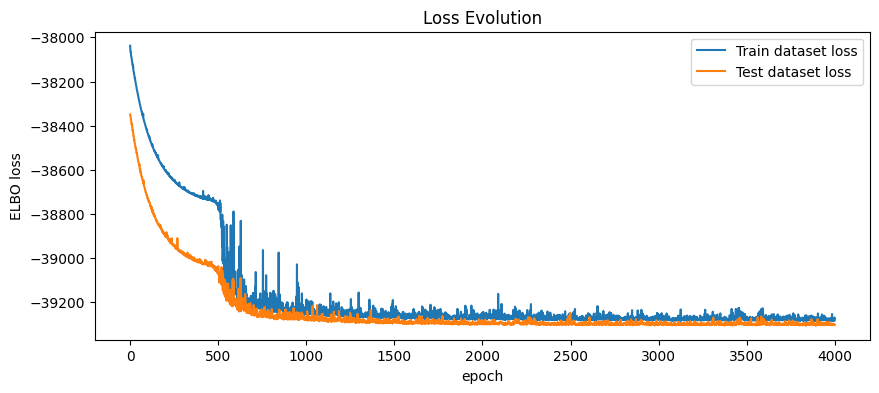

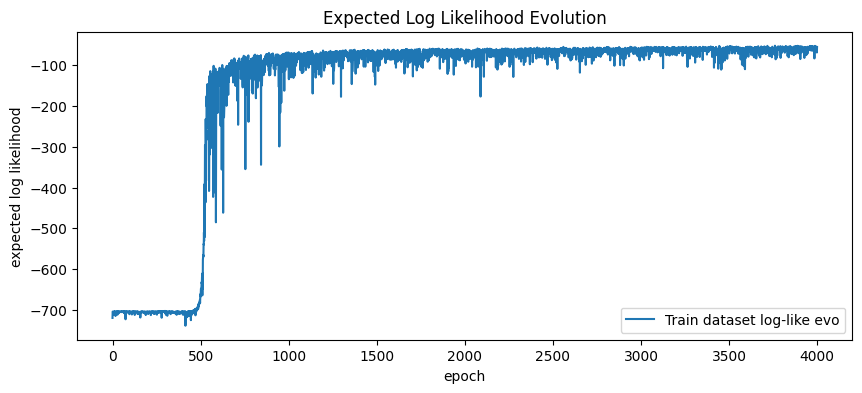

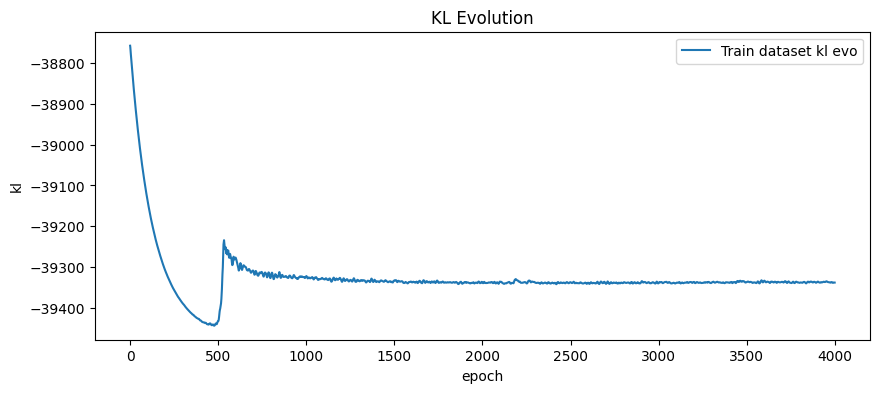

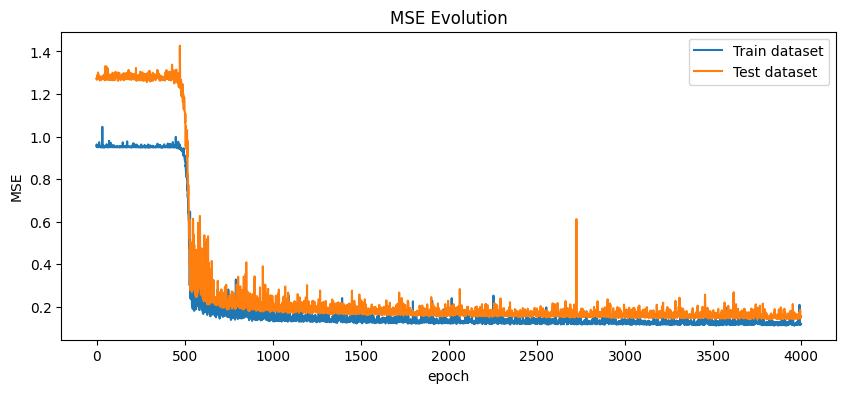

In [103]:
bnn_model = MeanFieldBNN(1, [20, 20], 1, noise_std=0.15)
# find value of noise_std that works best by trial and error, but this is of course
# inherently a bit contrived since we know we set input noise std to 0.15 in dataset generation
print(bnn_model)

opt = torch.optim.Adam(
    bnn_model.parameters(),
    lr = 1e-2
)

tr_loss_evo = []
tr_ll_evo = []
tr_kl_evo = []
te_loss_evo = []

tr_mse_loss_evo = []
te_mse_loss_evo = []
aux_loss = nn.MSELoss()

for epoch in tqdm(range(4000)):  # epochs
    opt.zero_grad()

    l, ll, kl = bnn_model.loss(x_tr, y_tr)
    tr_loss_evo.append(l.item())
    tr_ll_evo.append(ll.item())
    tr_kl_evo.append(kl.item())
    tr_mse_loss_evo.append(aux_loss(bnn_model(x_tr), y_tr.unsqueeze(0)).item())

    te_loss_evo.append(bnn_model.loss(x_te, y_te)[0].item())
    te_mse_loss_evo.append(aux_loss(bnn_model(x_te), y_te.unsqueeze(0)).item())

    l.backward()
    opt.step()

plt.rcParams["figure.figsize"] = (10, 4)

plt.plot(tr_loss_evo, label='Train dataset loss')
plt.plot(te_loss_evo, label='Test dataset loss')
plt.ylabel('ELBO loss')
plt.xlabel('epoch')
plt.legend()
plt.title('Loss Evolution')
plt.show()

plt.plot(tr_ll_evo, label='Train dataset log-like evo')
plt.ylabel('expected log likelihood')
plt.xlabel('epoch')
plt.legend()
plt.title('Expected Log Likelihood Evolution')
plt.show()

plt.plot(tr_kl_evo, label='Train dataset kl evo')
plt.ylabel('kl')
plt.xlabel('epoch')
plt.legend()
plt.title('KL Evolution')
plt.show()

plt.plot(tr_mse_loss_evo, label='Train dataset')
plt.plot(te_mse_loss_evo, label='Test dataset')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend()
plt.title('MSE Evolution')
plt.show()

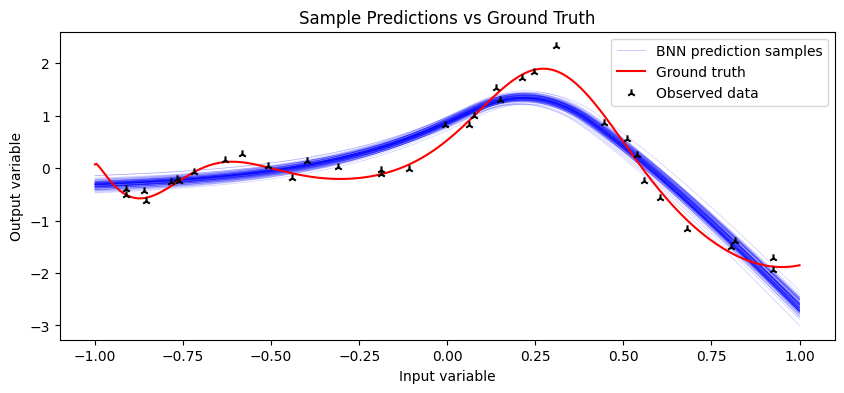

In [104]:
xs = np.linspace(-1, 1, 500)
num_samps = 100

preds = bnn_model(torch.FloatTensor(xs).unsqueeze(-1), num_samples=num_samps).squeeze(-1).detach().numpy()
plt.plot(xs, preds[0,...], color='blue', linewidth=0.5, alpha=0.3, label='BNN prediction samples')
plt.plot(xs, preds[1:,...].T, color='blue', linewidth=0.5, alpha=0.2)

ys = normalised_ground_truth(xs)
plt.title("Sample Predictions vs Ground Truth")
plt.plot(xs, ys, color='red', label='Ground truth', zorder=900)
plt.scatter(x_tr, y_tr, color='black', label='Observed data', marker='2', zorder=1000)
plt.xlabel('Input variable')
plt.ylabel('Output variable')
plt.legend()
plt.show()

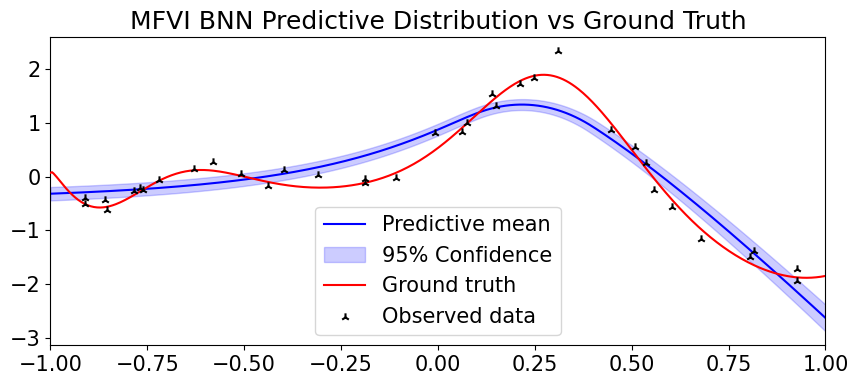

In [105]:
xs = np.linspace(-1, 1, 500)
num_samps = 1000

preds = bnn_model(torch.FloatTensor(xs).unsqueeze(-1), num_samples=num_samps).squeeze(-1).detach().numpy()
pred_mean = preds.mean(0)
pred_std = preds.std(0)
plt.plot(xs, pred_mean, color='blue', label='Predictive mean')
plt.fill_between(xs, pred_mean + 1.96*pred_std, pred_mean - 1.96*pred_std, color='blue', alpha=0.2, label='95% Confidence')

ys = normalised_ground_truth(xs)
plt.title("MFVI BNN Predictive Distribution vs Ground Truth", fontsize=18)
plt.plot(xs, ys, color='red', label='Ground truth', zorder=900)
plt.scatter(x_tr, y_tr, color='black', label='Observed data', marker='2', zorder=1000)
plt.legend(fontsize=15, loc='lower center')
plt.xlim([-1, 1])
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.grid()
plt.show()